In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize
import os 

%matplotlib inline

def cv2_imshow(img):
    figsize(15,15)
    return plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

########################################Blob Detector##############################################

# Setup SimpleBlobDetector parameters.
blobParams = cv2.SimpleBlobDetector_Params()

# Change thresholds
blobParams.minThreshold = 30
blobParams.maxThreshold = 255

# Filter by Area.
blobParams.filterByArea = True
blobParams.minArea = 1364   # minArea may be adjusted to suit for your experiment
blobParams.maxArea = 150000   # maxArea may be adjusted to suit for your experiment

# Filter by Circularity
blobParams.filterByCircularity = True
blobParams.minCircularity = 0.4

# Filter by Convexity
blobParams.filterByConvexity = True
blobParams.minConvexity = 0.87

# Filter by Inertia
blobParams.filterByInertia = True
blobParams.minInertiaRatio = 0.01

# Create a detector with the parameters
blobDetector = cv2.SimpleBlobDetector_create(blobParams)


In [2]:
objp = np.zeros((44, 3), np.float32)
for x in range(0, 11):
    for y in range(0, 4):
        objp[4*x+y] = (x*36, y*72 + (x%2)*36, 0)


In [3]:
img_folder = "./img_circles/"
imgs = os.listdir(img_folder)

In [4]:
objpoints = None # 3d point in real world space
imgpoints = None # 2d points in image plane.
for img in imgs:
    img = cv2.imread(img_folder + img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #keypoints = blobDetector.detect(gray)
    #im_with_keypoints = cv2.drawKeypoints(img, keypoints, np.array([]), (0,255,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    ret, corners = cv2.findCirclesGrid(gray, (4,11),
                        flags = cv2.CALIB_CB_ASYMMETRIC_GRID + cv2.CALIB_CB_CLUSTERING,
                                     blobDetector = blobDetector)   # Find the circle grid
    #cv2_imshow(im_with_keypoints)
    #print(keypoints)
    if corners is not None and ret:
        objpoints = np.array([objp]) if objpoints is None else np.append(objpoints, [objp], axis = 0)
        imgpoints = np.array([corners]) if imgpoints is None else np.append(imgpoints, [corners], axis = 0)
    else:
        print("Skiping " + img)


print(objpoints.shape)
print(imgpoints.shape)
(i1, i2, i3, i4) = imgpoints.shape;
imgpoints = imgpoints.reshape([i1, i2, i4])
print(imgpoints.shape)
  
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

print(mtx)
print(dist)

(18, 44, 3)
(18, 44, 1, 2)
(18, 44, 2)
[[3.16309826e+03 0.00000000e+00 1.99219579e+03]
 [0.00000000e+00 3.17278890e+03 1.50147508e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[-2.72726750e-02  2.22751951e-01  6.25806721e-04 -1.50276312e-04
  -3.43163740e-01]]


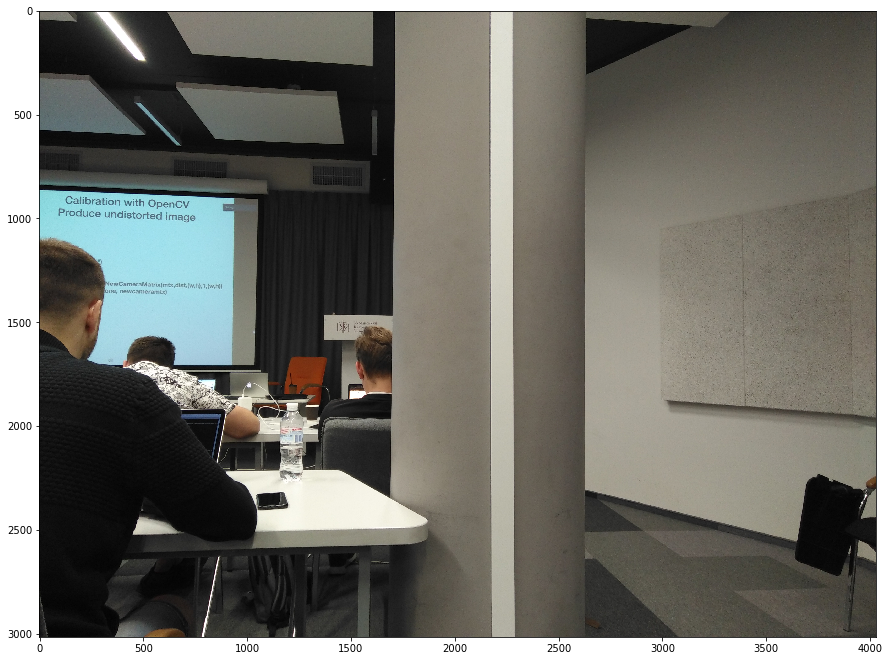

In [5]:
test = cv2.imread("Test_image.jpg")
cv2_imshow(test)


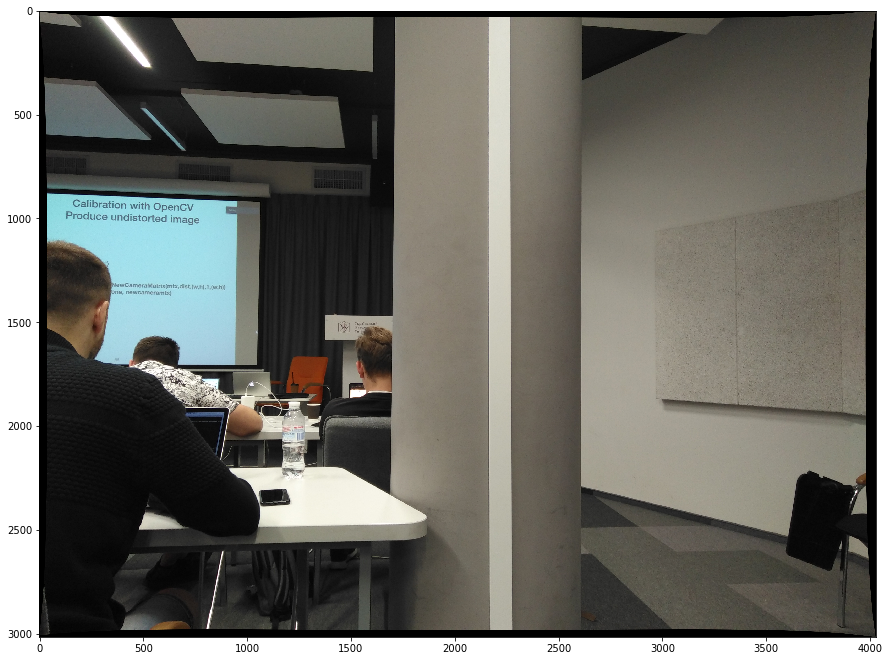

In [6]:
(h,w) = test.shape[:2]
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))
dst = cv2.undistort(test, mtx, dist, None, newcameramtx)
cv2_imshow(dst)

# We observe that image is changed only in corners. Most likely, because there was available only small amount of information for proper undistortion of these regions.

# If we choose region of interest, rescale and crop it, we receive image almost equal to the original one:

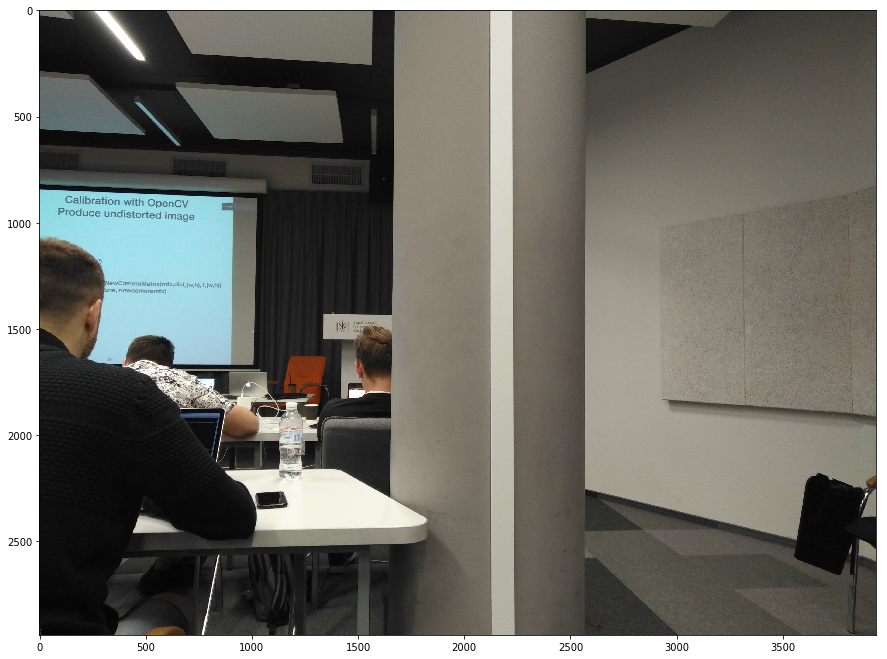

In [8]:
(h,w) = test.shape[:2]
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))
dst = cv2.undistort(test, mtx, dist, None, newcameramtx)
mapx,mapy = cv2.initUndistortRectifyMap(mtx,dist,None,newcameramtx,(w,h),5)
dst = cv2.remap(test,mapx,mapy,cv2.INTER_LINEAR)

x,y,w,h = roi
dst = dst[y:y+h, x:x+w]
dst = cv2.resize(dst, (0,0), fx=1, fy=1) 
cv2_imshow(dst)